## Necessary imports

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.11.0


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## Loading data

Data pipelines and exploration functions based on notebook: https://www.kaggle.com/code/achinih/flower-classification-cnn-models

In [3]:
import re
import numpy as np
import tensorflow as tf

from kaggle_datasets import KaggleDatasets

class DataLoad(tf.data.TFRecordDataset): # tf.data.TFRecordDataset
    
    AUTO = tf.data.experimental.AUTOTUNE
    
    def __init__(self, image_size=512, batch_size=16):
        
        self.BATCH_SIZE = batch_size
        
        assert image_size in (192,224,331,512)
        self.IMAGE_SIZE = [image_size, image_size]
        
        self.GCS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') + f'/tfrecords-jpeg-{image_size}x{image_size}'
        self.TRAINING_FILENAMES = tf.io.gfile.glob(self.GCS_PATH + '/train/*.tfrec')
        self.VALIDATION_FILENAMES = tf.io.gfile.glob(self.GCS_PATH + '/val/*.tfrec')
        self.TEST_FILENAMES = tf.io.gfile.glob(self.GCS_PATH + '/test/*.tfrec')
        
        self.NUM_TRAINING_IMAGES = self.count_data_items(self.TRAINING_FILENAMES)
        self.NUM_VALIDATION_IMAGES = self.count_data_items(self.VALIDATION_FILENAMES)
        self.NUM_TEST_IMAGES = self.count_data_items(self.TEST_FILENAMES)
        
        self.TRAINING_STEPS_PER_EPOCH = self.NUM_TRAINING_IMAGES // self.BATCH_SIZE
        self.TEST_STEPS_PER_EPOCH = self.NUM_TEST_IMAGES // self.BATCH_SIZE
        
        self.CLASSES = ['pink primrose',        'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',      'wild geranium',         # 00 - 04
                        'tiger lily',           'moon orchid',               'bird of paradise', 'monkshood',      'globe thistle',         # 05 - 09
                        'snapdragon',           "colt's foot",               'king protea',      'spear thistle',  'yellow iris',           # 10 - 14
                        'globe-flower',         'purple coneflower',         'peruvian lily',    'balloon flower', 'giant white arum lily', # 15 - 19
                        'fire lily',            'pincushion flower',         'fritillary',       'red ginger',     'grape hyacinth',        # 20 - 24
                        'corn poppy',           'prince of wales feathers',  'stemless gentian', 'artichoke',      'sweet william',         # 25 - 29
                        'carnation',            'garden phlox',              'love in the mist', 'cosmos',         'alpine sea holly',      # 30 - 34
                        'ruby-lipped cattleya', 'cape flower',               'great masterwort', 'siam tulip',     'lenten rose',           # 35 - 39
                        'barberton daisy',      'daffodil',                  'sword lily',       'poinsettia',     'bolero deep blue',      # 40 - 44
                        'wallflower',           'marigold',                  'buttercup',        'daisy',          'common dandelion',      # 45 - 49
                        'petunia',              'wild pansy',                'primula',          'sunflower',      'lilac hibiscus',        # 50 - 54
                        'bishop of llandaff',   'gaura',                     'geranium',         'orange dahlia',  'pink-yellow dahlia',    # 55 - 59
                        'cautleya spicata',     'japanese anemone',          'black-eyed susan', 'silverbush',     'californian poppy',     # 60 - 64
                        'osteospermum',         'spring crocus',             'iris',             'windflower',     'tree poppy',            # 65 - 69
                        'gazania',              'azalea',                    'water lily',       'rose',           'thorn apple',           # 70 - 74
                        'morning glory',        'passion flower',            'lotus',            'toad lily',      'anthurium',             # 75 - 79
                        'frangipani',           'clematis',                  'hibiscus',         'columbine',      'desert-rose',           # 80 - 84
                        'tree mallow',          'magnolia',                  'cyclamen ',        'watercress',     'canna lily',            # 85 - 89
                        'hippeastrum ',         'bee balm',                  'pink quill',       'foxglove',       'bougainvillea',         # 90 - 94
                        'camellia',             'mallow',                    'mexican petunia',  'bromelia',       'blanket flower',        # 95 - 99
                        'trumpet creeper',      'blackberry lily',           'common tulip',     'wild rose']                               # 100 - 103
    
    def count_data_items(self, filenames):
        n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
        return np.sum(n)

    #processing the images into floats from 0,1 and reshaping to the size required for a TPU.
    def decode_image(self, image_data):
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*self.IMAGE_SIZE, 3])
        return image
    
    #reading the labels for my images and returns a dataset with the image and label in a pair.
    def read_labeled_tfrecord(self, example):
        LABELED_TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "class": tf.io.FixedLenFeature([], tf.int64),
        }
        example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
        image = self.decode_image(example['image'])
        label = tf.cast(example['class'], tf.int32)
        return image, label
    
    #reading the unlabeled data to use for testing.
    def read_unlabeled_tfrecord(self, example):
        UNLABELED_TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "id": tf.io.FixedLenFeature([], tf.string),
        }
        example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
        image = self.decode_image(example['image'])
        idnum = example['id']
        return image, idnum

    #Reading multiple files at once to improve performance. 
    #Ordering data order decreases the speed and as the data will be shuffled later on anyways. 
    def load_dataset(self, filenames, labeled=True, ordered=False):
    
        ignore_order = tf.data.Options()
        if not ordered:
            ignore_order.experimental_deterministic = False # disabling order

        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=self.AUTO)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_labeled_tfrecord if labeled else self.read_unlabeled_tfrecord, num_parallel_calls=self.AUTO)
        # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
        return dataset
    
    def get_training_dataset(self, data_augment=None, ordered=False):
        assert data_augment is not None
        
        dataset = self.load_dataset(self.TRAINING_FILENAMES, labeled=True, ordered=ordered)
        dataset = dataset.repeat(10)
        dataset = dataset.map(data_augment, num_parallel_calls=self.AUTO)
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
        dataset = dataset.shuffle(2048)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(self.AUTO) # get next batch while training
        return dataset
    
    def get_validation_dataset(self, ordered=False):
        dataset = self.load_dataset(self.VALIDATION_FILENAMES, labeled=True, ordered=ordered)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTO)
        return dataset
    
    def get_test_dataset(self, ordered=False):
        dataset = self.load_dataset(self.TEST_FILENAMES, labeled=False, ordered=ordered)
#         dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(self.AUTO)
        return dataset

## History visualization

In [4]:
from matplotlib import pyplot as plt

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Model to implement

The data will load to data_load based on chosen `IMAGE_SIZE` and `BATCH_SIZE`. Then the model has to be compiled within `strategy.scope()`, compiled with chosen `optimizer`, `loss`, and `metrics`.

In [5]:
def data_augment(image, label):
    #data augmentation to prevent overfitting and to find more patterns.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label

In [6]:
image_size = 192
BATCH_SIZE = 16

IMAGE_SIZE = [image_size, image_size]

data_load = DataLoad(image_size=image_size, batch_size=BATCH_SIZE)

ds_train = data_load.get_training_dataset(data_augment=data_augment)
ds_valid = data_load.get_validation_dataset()
ds_test = data_load.get_test_dataset()

In [7]:
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
gu_seed=tf.keras.initializers.GlorotUniform(seed=1)

with strategy.scope():
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])

94765736/94765736 [==============================] - 4s 0us/step


In [8]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4

Now it is possible to augment the images within `data_augment` function, pick the number of `EPOCHS`, and fit the model.

In [9]:
def data_augment(self, image, label):
    #data augmentation to prevent overfitting and to find more patterns.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label

In [10]:
# Define training epochs
EPOCHS = 10

history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = EPOCHS,
    steps_per_epoch = data_load.TRAINING_STEPS_PER_EPOCH
)

Epoch 1/10
797/797 [==============================] - 68s 63ms/step - loss: 5.2163 - sparse_categorical_accuracy: 0.0501 - val_loss: 4.2057 - val_sparse_categorical_accuracy: 0.0862
Epoch 2/10
797/797 [==============================] - 38s 47ms/step - loss: 4.6127 - sparse_categorical_accuracy: 0.0796 - val_loss: 3.9676 - val_sparse_categorical_accuracy: 0.1350
Epoch 3/10
797/797 [==============================] - 37s 47ms/step - loss: 4.3965 - sparse_categorical_accuracy: 0.0884 - val_loss: 3.8767 - val_sparse_categorical_accuracy: 0.1255
Epoch 4/10
797/797 [==============================] - 36s 46ms/step - loss: 4.1776 - sparse_categorical_accuracy: 0.0990 - val_loss: 3.8065 - val_sparse_categorical_accuracy: 0.1417
Epoch 5/10
797/797 [==============================] - 35s 44ms/step - loss: 4.0643 - sparse_categorical_accuracy: 0.1080 - val_loss: 3.6569 - val_sparse_categorical_accuracy: 0.1422
Epoch 6/10
797/797 [==============================] - 35s 44ms/step - loss: 3.9517 - spars

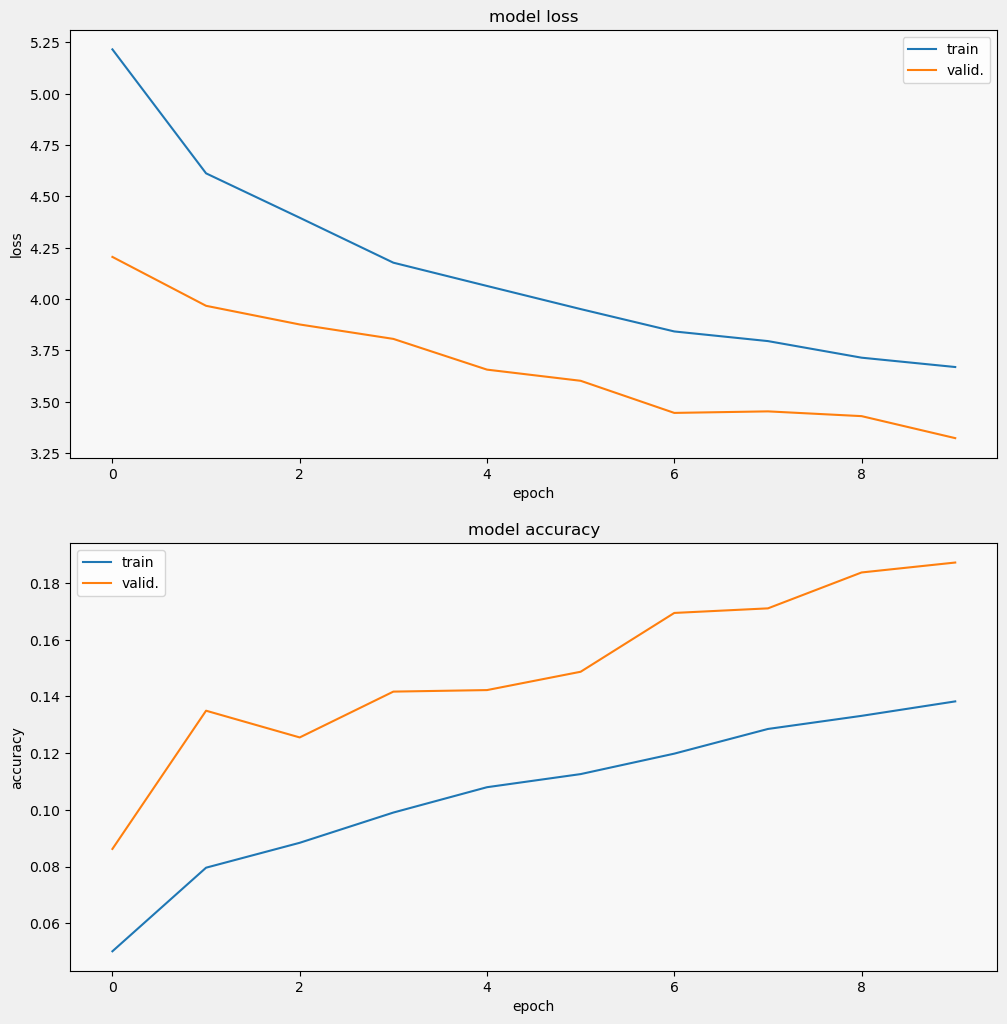

In [11]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

# Predictions to submit

In [12]:
print('Computing predictions...')
test_images_ds = ds_test.map(lambda image, idnum: image).batch(BATCH_SIZE)
probabilities = model.predict(test_images_ds, steps=data_load.TEST_STEPS_PER_EPOCH+1)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
462/462 [==============================] - 21s 37ms/step
[88 67 59 ... 14 49 49]


In [13]:
print('Generating submission.csv file...')
test_ids_ds = ds_test.map(lambda image, idnum: idnum)
test_ids = next(iter(test_ids_ds.batch(data_load.NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Generating submission.csv file...


In [14]:
np.save('history.npy',history.history)
model.save('model.h5')